In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# extracting data and doing the fit on velocity

In [2]:
from ANEMO.edfreader import read_edf

import pickle
with open('../demo/result/param_Fit_AM.pkl', 'rb') as fichier:
    param = pickle.load(fichier, encoding='latin1')
with open('../demo/data/enregistrement_AM_2017-10-23_100057.pkl', 'rb') as fichier:
    file_exp = pickle.load(fichier, encoding='latin1')

datafile = '../demo/data/enregistrement_AM_2017-10-23_100057.asc'
data = read_edf(datafile, 'TRIALID')

# Fonction

In [3]:
from ANEMO import ANEMO
ANEMO = ANEMO(file_exp)

In [4]:
arg = ANEMO.arg(data, 0, 0)
arg.N_trials

200

In [5]:
block = 0
trial = 13

In [8]:
arg = ANEMO.arg(data, trial, block)
start, start1 = arg.TargetOn, arg.TargetOn-arg.t_0
data_x = arg.data_x - (arg.data_x[arg.StimulusOf-arg.t_0])

debut, fin = 0, 15
kwarg = {'data_x': data_x, 'trackertime': arg.trackertime, 'dir_target': (arg.bino*2)-1, 'TargetOn': arg.TargetOn,
         'StimulusOf': arg.StimulusOf, 'saccades': arg.saccades,
         'param_fit': None,  'avant': debut, 'apres': fin, 'fct_fit': 'fct_position',
         'sup': True, 'time_sup': -280, 'step': 2}

sacc = np.zeros(len(arg.trackertime))
i = 0
for s in range(len(arg.saccades)):
    sacc[i] = arg.saccades[s][0]  # debut sacc
    sacc[i+1] = arg.saccades[s][1]  # fin sacc
    sacc[i+2] = arg.saccades[s][2]  # tps sacc
    i = i+3

popo = ANEMO.Fct_position(range(len(arg.trackertime)), data_x, sacc, int(len(arg.saccades)), (arg.bino*2)-1,
                param['start_anti'][block][trial] +
                start1, param['a_anti'][block][trial],
                param['latency'][block][trial] +
                start1, param['tau'][block][trial],
                param['maxi'][block][trial], arg.t_0, arg.px_per_deg,  debut, fin,
                do_whitening=False)

fi = {}
for do_whitening in [False, True]:

    # print(do_whitening)
    kwarg.update(do_whitening=do_whitening)
    c = ANEMO.Fit_trial(popo, **kwarg)

    fi['%s'%do_whitening] = ( ANEMO.Fct_position(range(len(arg.trackertime)), data_x, sacc,
                                          int(len(arg.saccades)), (arg.bino*2)-1,
                                          c.values['start_anti'], c.values['a_anti'],
                                          c.values['latency'], c.values['tau'],
                                          c.values['maxi'], arg.t_0, arg.px_per_deg, debut,
                                          fin, do_whitening=False))

# Comparaison

In [9]:
def deco(axs) :
    axs.axvspan(arg.StimulusOn-start, arg.StimulusOf-start, color='k', alpha=0.2)
    axs.axvspan(arg.StimulusOf-start, arg.TargetOn-start, color='r', alpha=0.2)
    axs.axvspan(arg.TargetOn-start, arg.TargetOff-start, color='k', alpha=0.15)
    for s in range(len(arg.saccades)) :
        axs.axvspan(arg.saccades[s][0]-start, arg.saccades[s][1]-start, color='k', alpha=0.2)

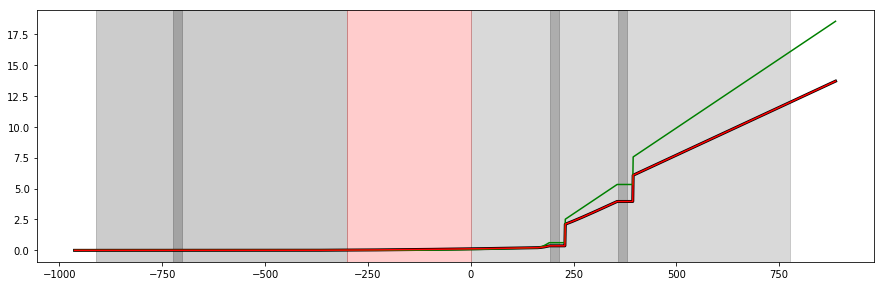

In [11]:
fig_width= 15
fig, ax = plt.subplots(1, 1, figsize=(1*fig_width, 1*(fig_width/2)/1.6180))

deco(ax)
ax.plot(range(len(arg.trackertime))-start1, popo, 'k', lw=3)
ax.plot(range(len(arg.trackertime))-start1, fi['True'], 'g')
ax.plot(range(len(arg.trackertime))-start1, fi['False'], 'r');